# Modeling
---

### ARIMA Modeling

In [1]:
import pandas as pd
import numpy as np
import sktime
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
np.random.seed(42)

In [15]:
df = pd.read_csv('../data/cleaned/campus5.csv', index_col='Timestamp')
df.index = pd.to_datetime(df.index)
#df1 = pd.date_range(start = df.index[0], end = df.index[-1], freq = '15min')
#df = df.reindex(df1, fill_value = 0)

In [16]:
hourly = df['SolarGeneration'].resample('H').mean().ffill()

In [17]:
hourly_train, hourly_test = temporal_train_test_split(hourly, test_size=0.15)

In [18]:
hourly_train.isnull().sum()

0

Gridsearching Arima model for p and q parameters (d was discovered to be 0 in early notebook)

In [ ]:
# ONLY RUN THIS CELL IF PREPARED TO RUN IT FOR AT LEAST 48 HOURS!!!!
#best_aic = 99 * (10 ** 160)
#best_p = 0
#best_q = 0
#for p in range(25):
#    for q in range(25):
#        try:
#            print(f'Attempting ARIMA({p}, 0, {q})')
#            arima = ARIMA(endog=hourly_train, order=(p, 0, q))
#            model = arima.fit()
#
#            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')
#            if model.aic < best_aic:
#                best_aic = model.aic
#                best_p = p
#                best_q = q
#        except:
#            pass
#print()
#print()
#print('MODEL FINISHED!')
#print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
#print(f'This model has an AIC of {best_aic}.')

<img src="../images/arima_gridsearch.png"/>

In [9]:
arima = ARIMA(endog = hourly_train, order = (10, 0, 7))
model = arima.fit()
preds = model.predict(start = hourly_test.index[0], end = hourly_test.index[-1])

C:\Users\jeffr\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jeffr\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jeffr\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


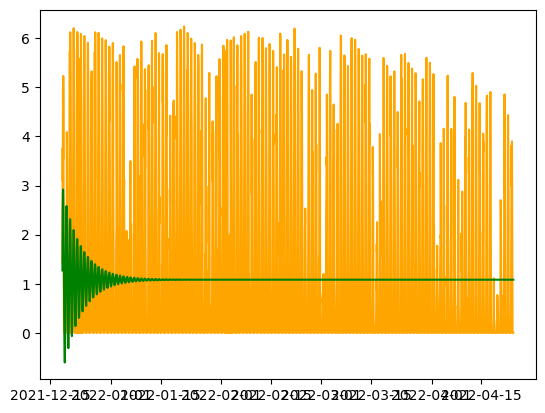

In [10]:
plt.plot(hourly_test.index, hourly_test, color = 'orange')
plt.plot(hourly_test.index, preds, color = 'green')

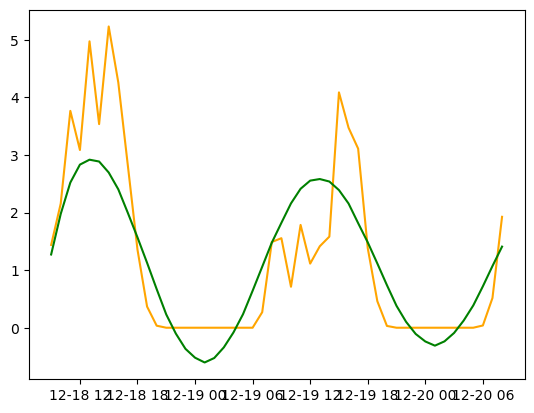

In [11]:
plt.plot(hourly_test.index[:48], hourly_test[:48], color = 'orange')
plt.plot(hourly_test.index[:48], preds[:48], color = 'green')

In [12]:
mean_squared_error(hourly_test, preds, squared = False)

1.9369231123182369

In [13]:
mean_absolute_error(hourly_test, preds)

1.5243797502383278

The result was basically a single value predicted across the entire time. It is not much better than the Naive Forecasting.

---

### Investigating Lagged Models

In [79]:
df = pd.read_csv('../data/cleaned/camp5_shifted.csv', index_col = 'Timestamp')
df.index = pd.to_datetime(df.index)

In [80]:
df.head()

,SolarGeneration,lag1,lag2,lag3,lag5,lag6,lag86
Timestamp,,,,,,,
2020-01-01 00:15:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:45:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2020-01-01 01:15:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [81]:
df.dropna(inplace = True)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'SolarGeneration'),
                                                    df['SolarGeneration'],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [83]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f'Training Score: {lr.score(X_train, y_train)}')
print(f'Testing Score: {lr.score(X_test, y_test)}')
preds = lr.predict(X_test)

Training Score: 0.8746372109339293
Testing Score: 0.8992121343350239


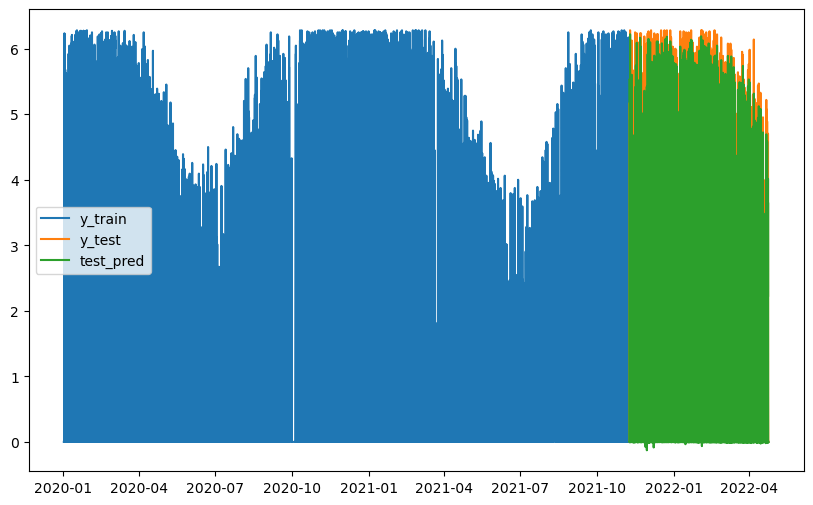

In [85]:
plt.figure(figsize = (10, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, preds, label = 'test_pred')
plt.legend();

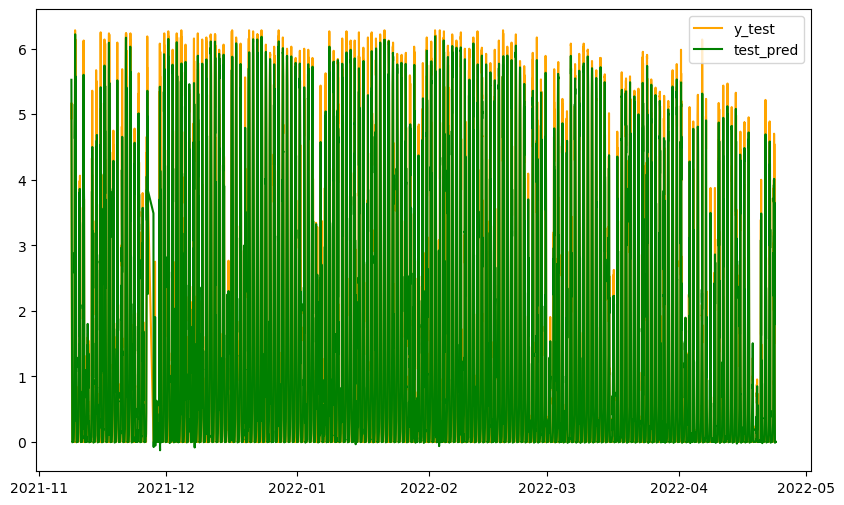

In [93]:
plt.figure(figsize = (10, 6))
plt.plot(y_test, label = 'y_test', color = 'orange')
plt.plot(y_test.index, preds, label = 'test_pred', color = 'green')
plt.legend();

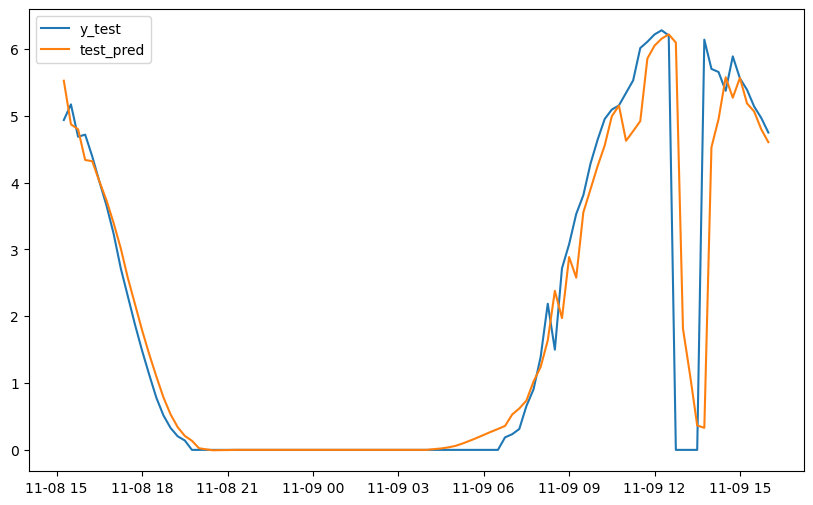

In [95]:
#Examining the first 100 15-min intervals
plt.figure(figsize = (10, 6))
plt.plot(y_test[:100], label = 'y_test')
plt.plot(y_test.index[:100], preds[:100], label = 'test_pred')
plt.legend();

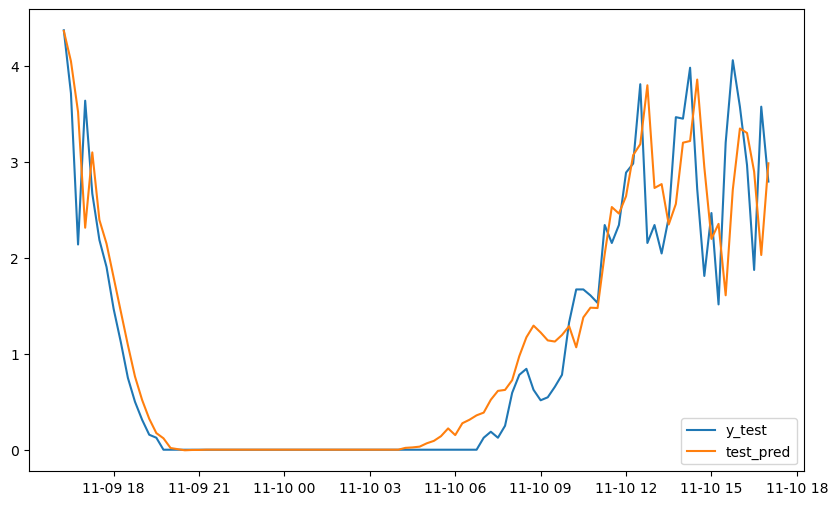

In [89]:
#Examining the second 100 15-min intervals
plt.figure(figsize = (10, 6))
plt.plot(y_test[100:200], label = 'y_test')
plt.plot(y_test.index[100:200], preds[100:200], label = 'test_pred')
plt.legend();

Most of the preds look like just the true values shifted over by 15 min or so. However, looking closely, especially when looking at the second hundred intervals graphed (specifically around 9am on 11-10) the predictions and true values diverge briefly. Which means the predictions aren't just relying on the the first lagged value. This is shown by the the linear regression model's coefficients below:

In [97]:
pd.DataFrame(index = X_train.columns, data = lr.coef_)

,0
lag1,0.692481
lag2,0.102760
lag3,0.121441
lag5,0.002748
lag6,-0.021108
lag86,0.101447


In [91]:
mean_squared_error(y_test, preds, squared = False)

0.629206887443432

In [92]:
mean_absolute_error(y_test, preds)

0.26011420254653045

---
This lagged investigation demonstrates if we could have a model that updated every 15 min, our RMSE and MAE would be of those reported just above. Therefore, these are the scores for campus 5 I will be attempting to beat in the RNN investigation.

---

## Holt-Winters Investigation

C:\Users\jeffr\anaconda3\lib\site-packages\sktime\forecasting\ets.py:253: UserWarning: Warning: time series is not strictly positive, multiplicative components are ommitted
  warnings.warn(
C:\Users\jeffr\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jeffr\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


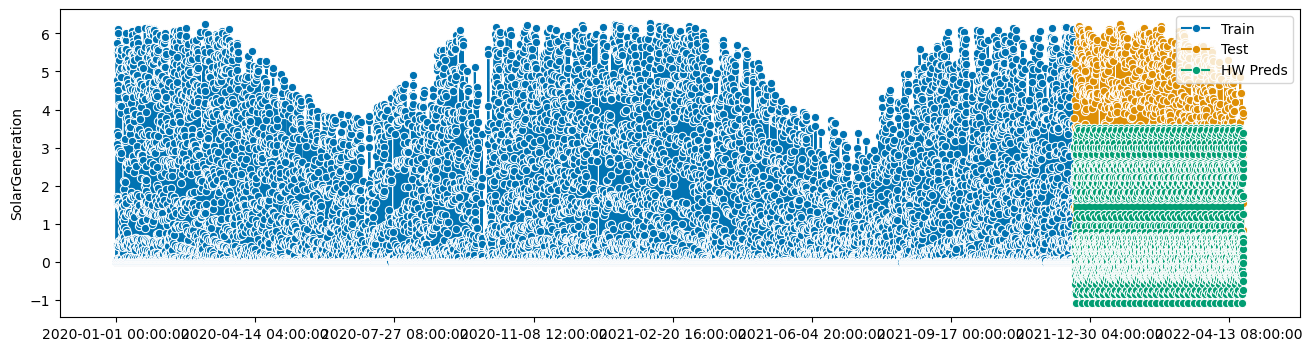

In [19]:
model = AutoETS(auto = True, sp = 96)
model.fit(hourly_train)
hw_preds = model.predict(hourly_test.index)
plot_series(hourly_train, hourly_test, hw_preds, labels = ['Train', 'Test', 'HW Preds']);

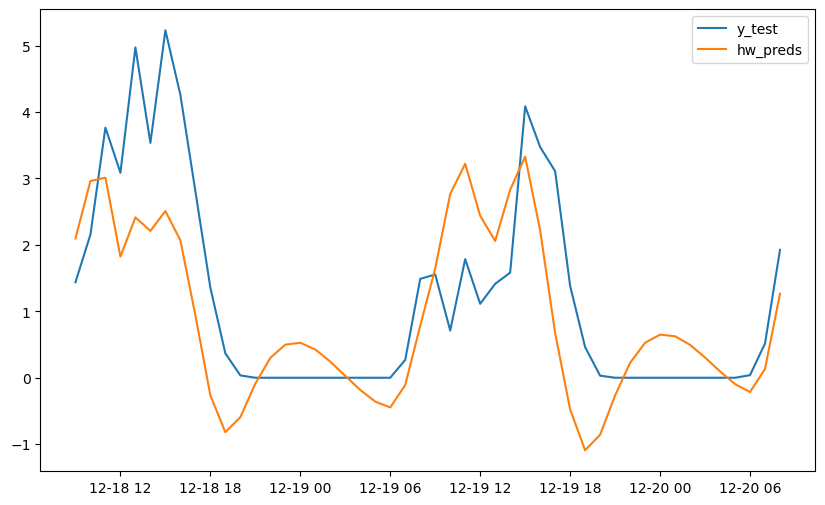

In [23]:
plt.figure(figsize = (10, 6))
plt.plot(hourly_test[:48], label = 'y_test')
plt.plot(hourly_test.index[:48], hw_preds[:48], label = 'hw_preds')
plt.legend();

In [20]:
mean_squared_error(hourly_test, hw_preds, squared = False)

1.3384617031879

In [21]:
mean_absolute_error(hourly_test, hw_preds)

0.9266692494040881